
# Disease Prediction from Patient Statements — **PyTorch LSTM** (No-TF, Colab-friendly)

This notebook avoids TensorFlow and version pinning by using **PyTorch** only. It implements:
- Clean text preprocessing
- Label encoding (scikit-learn)
- Custom tokenizer + vocabulary
- Sequence padding & efficient `DataLoader`s
- LSTM classifier with embeddings
- Early stopping on validation loss
- Evaluation: accuracy, classification report, confusion matrix
- Inference helper for new statements
- Saves: `model_state.pt`, `vocab.json`, `label_encoder_classes.json`

> Assumes your CSV has `statement` (text) and `status` (label). Change `TEXT_COL` and `LABEL_COL` if needed.


In [13]:

#@title Imports (uses Colab's preinstalls; no extra installs required)
import os, re, json, math, random
from collections import Counter

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [14]:

#@title Config
CSV_PATH = "Combined Data.csv"  #@param {type:"string"}
TEXT_COL = "statement"          #@param {type:"string"}
LABEL_COL = "status"            #@param {type:"string"}
MAX_VOCAB = 20000               #@param {type:"integer"}
MAX_LEN = 64                    #@param {type:"integer"}
EMBED_DIM = 128                 #@param {type:"integer"}
HIDDEN_SIZE = 128               #@param {type:"integer"}
NUM_LAYERS = 1                  #@param {type:"integer"}
DROPOUT = 0.3                   #@param {type:"number"}
BATCH_SIZE = 64                 #@param {type:"integer"}
EPOCHS = 100                     #@param {type:"integer"}
LR = 3e-4                       #@param {type:"number"}

# If on Colab, upload or mount Drive as needed:
# from google.colab import files
# up = files.upload(); CSV_PATH = list(up.keys())[0]


In [15]:

#@title Load & Clean Data
df = pd.read_csv(CSV_PATH, encoding="utf-8", engine="python", on_bad_lines="skip")
print("Shape:", df.shape, "Columns:", df.columns.tolist())
df = df.dropna(subset=[TEXT_COL, LABEL_COL]).copy()
if 'Unnamed: 0' in df.columns: df = df.drop(columns=['Unnamed: 0'])

def clean_text(s:str)->str:
    s = s.lower()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9.,;:!?()'%\-\s]", "", s)
    return s.strip()

df["text_clean"] = df[TEXT_COL].astype(str).apply(clean_text)
df = df[df["text_clean"].str.len() > 0].reset_index(drop=True)
df.head(3)


Shape: (53043, 3) Columns: ['Unnamed: 0', 'statement', 'status']


,statement,status,text_clean
0,oh my gosh,Anxiety,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,"all wrong, back off dear, forward doubt. stay ..."


In [16]:

#@title Encode Labels & Split
le = LabelEncoder()
y = le.fit_transform(df[LABEL_COL].astype(str))
class_names = list(le.classes_); num_classes = len(class_names)
with open("label_encoder_classes.json","w") as f: json.dump(class_names, f)

X_train, X_temp, y_train, y_temp = train_test_split(
    df["text_clean"].values, y, test_size=0.2, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

len(X_train), len(X_val), len(X_test), num_classes, class_names


(42144,
 5268,
 5269,
 7,
 ['Anxiety',
  'Bipolar',
  'Depression',
  'Normal',
  'Personality disorder',
  'Stress',
  'Suicidal'])

In [17]:

#@title Tokenizer, Vocabulary, and Encoding
PAD, UNK = "<PAD>", "<UNK>"

def simple_tokenize(s:str):
    # whitespace + basic punctuation split
    return re.findall(r"[a-z0-9']+|[.,;:!?()-]", s)

# Build vocab from training data only
freq = Counter()
for t in X_train:
    freq.update(simple_tokenize(t))

# Most common up to MAX_VOCAB-2 (keep space for PAD & UNK)
most_common = [w for w,_ in freq.most_common(MAX_VOCAB-2)]
itos = [PAD, UNK] + most_common
stoi = {w:i for i,w in enumerate(itos)}

def encode(text, max_len=64):
    ids = [stoi.get(tok, stoi[UNK]) for tok in simple_tokenize(text)]
    ids = ids[:max_len]
    if len(ids) < max_len:
        ids = ids + [stoi[PAD]]*(max_len-len(ids))
    return np.array(ids, dtype=np.int64)

vocab_size = len(itos)
vocab_size, itos[:10]


(20000, ['<PAD>', '<UNK>', 'i', '.', 'to', ',', 'and', 'the', 'my', 'a'])

In [18]:

#@title Datasets & Loaders
class TextDataset(Dataset):
    def __init__(self, texts, labels, max_len=64):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        x = encode(self.texts[idx], self.max_len)
        y = int(self.labels[idx])
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)

train_ds = TextDataset(X_train, y_train, MAX_LEN)
val_ds   = TextDataset(X_val, y_val, MAX_LEN)
test_ds  = TextDataset(X_test, y_test, MAX_LEN)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
len(train_dl), len(val_dl), len(test_dl)


(659, 83, 83)

In [19]:

#@title LSTM Model (Embedding → LSTM → FC)
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers, num_classes, pad_idx=0, dropout=0.3):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(input_size=embed_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True,
                            dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    def forward(self, x):
        # x: (B, T)
        e = self.emb(x)              # (B, T, E)
        out, (h, c) = self.lstm(e)   # out: (B, T, 2H), h: (2L, B, H)
        # Take final time-step from out (or mean-pool)
        last = out[:, -1, :]         # (B, 2H)
        last = self.dropout(last)
        return self.fc(last)

model = LSTMClassifier(vocab_size, EMBED_DIM, HIDDEN_SIZE, NUM_LAYERS, num_classes, pad_idx=stoi[PAD], dropout=DROPOUT).to(device)
optim = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

sum(p.numel() for p in model.parameters())/1e6, model


(2.825991,
 LSTMClassifier(
   (emb): Embedding(20000, 128, padding_idx=0)
   (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
   (dropout): Dropout(p=0.3, inplace=False)
   (fc): Linear(in_features=256, out_features=7, bias=True)
 ))

In [20]:

#@title Training Utilities (with Early Stopping)
def run_epoch(dl, train=True):
    model.train(mode=train)
    total_loss, total_correct, total_n = 0.0, 0, 0
    for xb, yb in dl:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                optim.zero_grad(); loss.backward(); optim.step()
        total_loss += loss.item() * xb.size(0)
        total_correct += (logits.argmax(1) == yb).sum().item()
        total_n += xb.size(0)
    return total_loss/total_n, total_correct/total_n

best_val = float("inf"); best_state = None; patience, wait = 3, 0
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_dl, train=True)
    va_loss, va_acc = run_epoch(val_dl, train=False)
    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
    print(f"Epoch {epoch:02d} | train_loss {tr_loss:.4f} acc {tr_acc:.3f} | val_loss {va_loss:.4f} acc {va_acc:.3f}")
    if va_loss < best_val:
        best_val, wait = va_loss, 0
        best_state = {k:v.cpu() for k,v in model.state_dict().items()}
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

# load best
if best_state is not None:
    model.load_state_dict(best_state)


Epoch 01 | train_loss 1.2710 acc 0.514 | val_loss 1.1211 acc 0.554
Epoch 02 | train_loss 1.0896 acc 0.560 | val_loss 1.0391 acc 0.574
Epoch 03 | train_loss 1.0037 acc 0.594 | val_loss 0.9717 acc 0.608
Epoch 04 | train_loss 0.9160 acc 0.630 | val_loss 0.8903 acc 0.631
Epoch 05 | train_loss 0.8469 acc 0.656 | val_loss 0.8703 acc 0.649
Epoch 06 | train_loss 0.7922 acc 0.677 | val_loss 0.8578 acc 0.660
Epoch 07 | train_loss 0.7454 acc 0.698 | val_loss 0.8237 acc 0.673
Epoch 08 | train_loss 0.7096 acc 0.713 | val_loss 0.8088 acc 0.675
Epoch 09 | train_loss 0.6722 acc 0.729 | val_loss 0.8261 acc 0.675
Epoch 10 | train_loss 0.6393 acc 0.746 | val_loss 0.7894 acc 0.689
Epoch 11 | train_loss 0.6062 acc 0.760 | val_loss 0.7865 acc 0.694
Epoch 12 | train_loss 0.5684 acc 0.779 | val_loss 0.8161 acc 0.696
Epoch 13 | train_loss 0.5356 acc 0.792 | val_loss 0.8145 acc 0.694
Epoch 14 | train_loss 0.5010 acc 0.807 | val_loss 0.7810 acc 0.699
Epoch 15 | train_loss 0.4690 acc 0.822 | val_loss 0.8069 acc 0

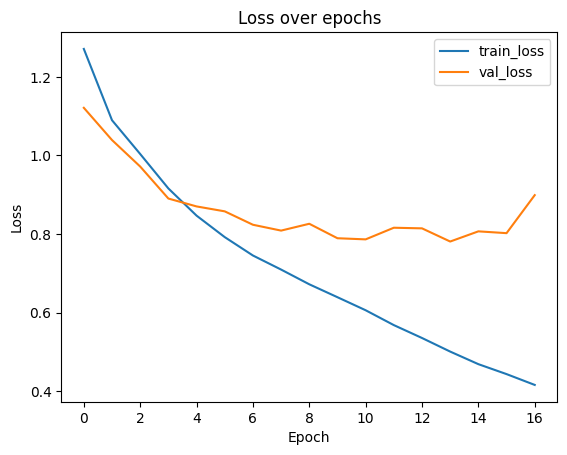

In [ ]:

#@title Plot Training Curves
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss over epochs"); plt.legend(); plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy over epochs"); plt.legend(); plt.show()


Test Accuracy: 0.7014613778705637

Classification report:
                      precision    recall  f1-score   support

             Anxiety       0.70      0.74      0.72       384
             Bipolar       0.69      0.66      0.67       278
          Depression       0.62      0.74      0.68      1541
              Normal       0.94      0.86      0.90      1635
Personality disorder       0.17      0.07      0.09       107
              Stress       0.39      0.41      0.40       258
            Suicidal       0.60      0.54      0.57      1066

            accuracy                           0.70      5269
           macro avg       0.59      0.57      0.58      5269
        weighted avg       0.70      0.70      0.70      5269



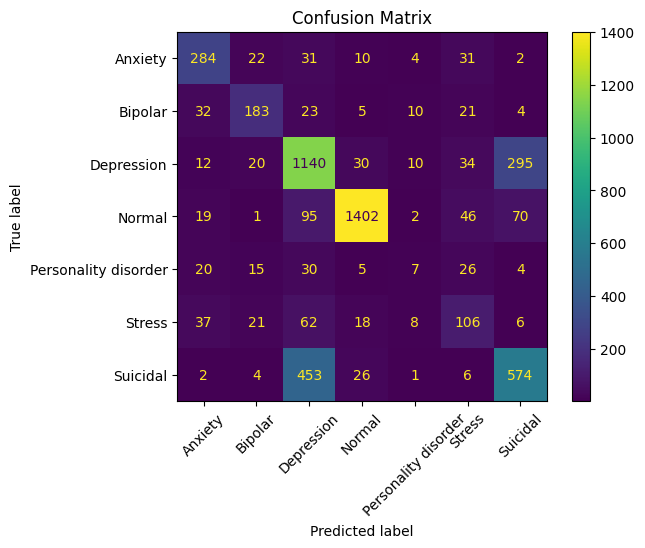

In [25]:

#@title Evaluate on Test Set
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        all_preds.extend(logits.argmax(1).cpu().numpy().tolist())
        all_true.extend(yb.numpy().tolist())

test_acc = (np.array(all_preds) == np.array(all_true)).mean()
print("Test Accuracy:", test_acc)

print("\nClassification report:")
print(classification_report(all_true, all_preds, target_names=class_names))

cm = confusion_matrix(all_true, all_preds)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(xticks_rotation=45)
plt.title("Confusion Matrix"); plt.show()


In [26]:

#@title Save Model & Vocab
torch.save(model.state_dict(), "model_state.pt")
with open("vocab.json","w") as f:
    json.dump({"itos": itos}, f)
with open("label_encoder_classes.json","w") as f:
    json.dump(class_names, f)
print("Saved: model_state.pt, vocab.json, label_encoder_classes.json")


Saved: model_state.pt, vocab.json, label_encoder_classes.json


In [27]:

#@title Inference Helper
def predict_statement(texts, max_len=64):
    if isinstance(texts, str):
        texts = [texts]
    xs = np.stack([encode(clean_text(t), max_len) for t in texts])
    with torch.no_grad():
        logits = model(torch.from_numpy(xs).to(device))
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        idx = probs.argmax(1)
    labels = [class_names[i] for i in idx]
    conf = probs.max(1)
    return pd.DataFrame({"text": texts, "pred_label": labels, "confidence": conf})

# Try it:
predict_statement(["I can't sleep and my mind races a lot.", "sharp pain in lower abdomen and fever"])


,text,pred_label,confidence
0,I can't sleep and my mind races a lot.,Normal,0.802631
1,sharp pain in lower abdomen and fever,Anxiety,0.978386
